In [1]:
library('tidyverse')
library('tidymodels')

library('ggbeeswarm')
library('ggrepel')

library('gender')
library('genderdata')

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 0.0.2 ──
✔ broom     0.5.2       ✔ recipes   0.1.5  
✔ dials     0.0.2       ✔ rsample   0.0.4  
✔ infer     0.4.0.1     ✔ yardstick 0.0.3  
✔ parsnip   0.0.2       
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()


In [2]:
sc_salaries <-
    read_csv(
        'FOIA Accountability File 06302019 Revised.csv',
        col_names=FALSE
    ) %>%
    mutate(
        `First_name`=`X2`,
        `Last_name`=`X1`,
        `Agency`=as.factor(`X3`),
        `Job`=as.factor(`X4`),
        `Salary`=parse_number(`X5`)
    ) %>%
    select(`First_name`:`Salary`)

sc_salaries %>%
    arrange(`Salary`) %>%
    tail(n=20)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_character(),
  X3 = col_character(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character()
)


First_name,Last_name,Agency,Job,Salary
BOBBY,BENTLEY,UNIVERSITY OF SOUTH CAROLINA,ATHLETICS COACH,400000.0
ERIC,WOLFORD,UNIVERSITY OF SOUTH CAROLINA,ATHLETICS COACH,400000.0
JOAN,GABEL,UNIVERSITY OF SOUTH CAROLINA,PROVOST,400400.0
GARY,GILMORE,COASTAL CAROLINA UNIVERSITY,ATHLETICS COACH,402000.0
MARTIN,MORAD,UNIVERSITY OF SOUTH CAROLINA,PROFESSOR,405368.0
PRAKASH,NAGARKATTI,UNIVERSITY OF SOUTH CAROLINA,VICE PRESIDENT,405855.0
JAMES,BYINGTON,COASTAL CAROLINA UNIVERSITY,PROVOST,409737.0
ANGELA,SHARKEY,UNIVERSITY OF SOUTH CAROLINA,CLINICAL PROFESSOR,432000.0
JOHN,SCOTT,UNIVERSITY OF SOUTH CAROLINA,ATHLETICS COACH,435000.0
EDWARD,WALTON,UNIVERSITY OF SOUTH CAROLINA,SENIOR VICE PRESIDENT,438186.0


In [3]:
name_to_sex <-
    gender(sc_salaries$`First_name` %>% unique, method="ssa") %>%
    select(
        `First_name`=`name`,
        `Predicted_sex`=`gender`
    ) %>%
    mutate(`Predicted_sex`=factor(`Predicted_sex`))

name_to_sex %>% head

First_name,Predicted_sex
AAISHA,female
AARON,male
ABBAS,male
ABBI,female
ABBIGAIL,female
ABBY,female


In [4]:
sc_salaries_with_sex <-
    left_join(sc_salaries, name_to_sex, by=c('First_name'))

summary(sc_salaries_with_sex$`Predicted_sex`)

female   male   NA's 
 10666  10572   1139

In [5]:
sc_salaries_with_sex <-
    left_join(sc_salaries, name_to_sex, by=c('First_name')) %>%
    filter(!is.na(`Predicted_sex`))

summary(sc_salaries_with_sex$`Predicted_sex`)

female   male 
 10666  10572

In [6]:
count_sexes <- function(df, sex) {
    nrow(df %>% filter(`Predicted_sex` == sex))
}

fit_model <- function(df) {
    t.test(`Salary`~`Predicted_sex`, df) %>% 
    tidy
}

diff_salaries <- 
    sc_salaries_with_sex %>%
    group_by(`Agency`, `Job`) %>%
    nest() %>%
    mutate(
        `f_count`=map(data, count_sexes, sex='female'),
        `m_count`=map(data, count_sexes, sex='male'),
    ) %>%
    filter(
        `f_count` > 5,
        `m_count` > 5
    ) %>%
    mutate(
        `my_res`=map(data, fit_model)
    ) %>%
    unnest(my_res, f_count, m_count, .drop = T) %>%
    mutate(`adj_p`=p.adjust(`p.value`, method="fdr")) %>%
    arrange(`p.value`)

diff_salaries %>% filter(`adj_p` < 0.25)

Agency,Job,f_count,m_count,estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative,adj_p
AIKEN TECHNICAL COLLEGE,INSTRUCTOR,10,8,8082.400,61572.90,53490.50,5.703833,0.0001411959,10.92181,4960.851,11203.949,Welch Two Sample t-test,two.sided,0.01536393
CLEMSON UNIVERSITY,PROFESSOR,52,165,-19894.327,116248.25,136142.58,-3.973014,0.0001544113,79.98879,-29859.320,-9929.334,Welch Two Sample t-test,two.sided,0.01536393
UNIVERSITY OF SOUTH CAROLINA,ASSISTANT PROFESSOR,198,173,-12591.298,76257.06,88848.36,-3.567230,0.0004255388,274.63057,-19540.030,-5642.566,Welch Two Sample t-test,two.sided,0.02822741
UNIVERSITY OF SOUTH CAROLINA,PROGRAM MANAGER III,10,8,-21889.675,101399.20,123288.88,-3.881823,0.0013789835,15.61075,-33868.132,-9911.218,Welch Two Sample t-test,two.sided,0.06294617
DEPARTMENT OF TRANSPORTATION,ENG/ENG ASSOC II,37,186,-2954.558,59215.22,62169.77,-3.297181,0.0015815620,65.38042,-4743.968,-1165.148,Welch Two Sample t-test,two.sided,0.06294617
UNIVERSITY OF SOUTH CAROLINA,ADMINISTRATIVE COORDINATOR II,72,9,-7985.403,61868.71,69854.11,-3.745493,0.0031050147,11.26913,-12664.273,-3306.533,Welch Two Sample t-test,two.sided,0.10298299
MEDICAL UNIVERSITY OF SC,RESEARCH ASSISTANT PROFESSOR,14,20,26873.929,98623.43,71749.50,2.960634,0.0078901894,19.45392,7905.330,45842.527,Welch Two Sample t-test,two.sided,0.20208753
UNIVERSITY OF SOUTH CAROLINA,ASSOCIATE PROFESSOR,200,249,-6885.318,85512.06,92397.38,-2.658840,0.0081241216,444.36587,-11974.692,-1795.943,Welch Two Sample t-test,two.sided,0.20208753
UNIVERSITY OF SOUTH CAROLINA,PROFESSOR,146,292,-12489.510,121774.63,134264.14,-2.552135,0.0111575752,329.30174,-22116.465,-2862.556,Welch Two Sample t-test,two.sided,0.24670638


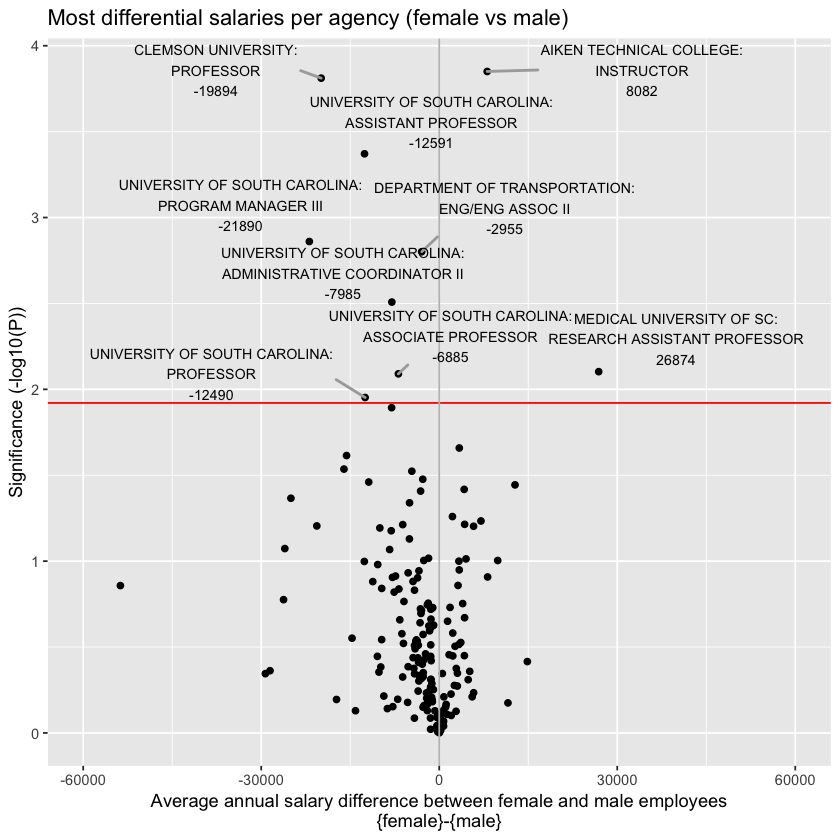

In [7]:
diff_salaries %>%
    mutate(`Label`=diff_salaries %>% str_glue_data("{Agency}:\n{Job}\n{round(estimate)}")) %>%
    ggplot(aes(x=`estimate`, y=-log10(`p.value`))) +
        geom_point() +
        geom_hline(yintercept=-log10(0.012), color="red") +
        geom_vline(xintercept=0, color="gray") +
        geom_text_repel(
            data=. %>% filter(`adj_p` < .25),
            aes(label=`Label`),
            size=3,
            nudge_y=.2,
            nudge_x=.2,
            segment.size=0.8,
            segment.color="darkgray"
        ) +
        xlim(-60000, 60000) +
        labs(
            title="Most differential salaries per agency (female vs male)",
            x="Average annual salary difference between female and male employees\n{female}-{male}",
            y="Significance (-log10(P))"
        )

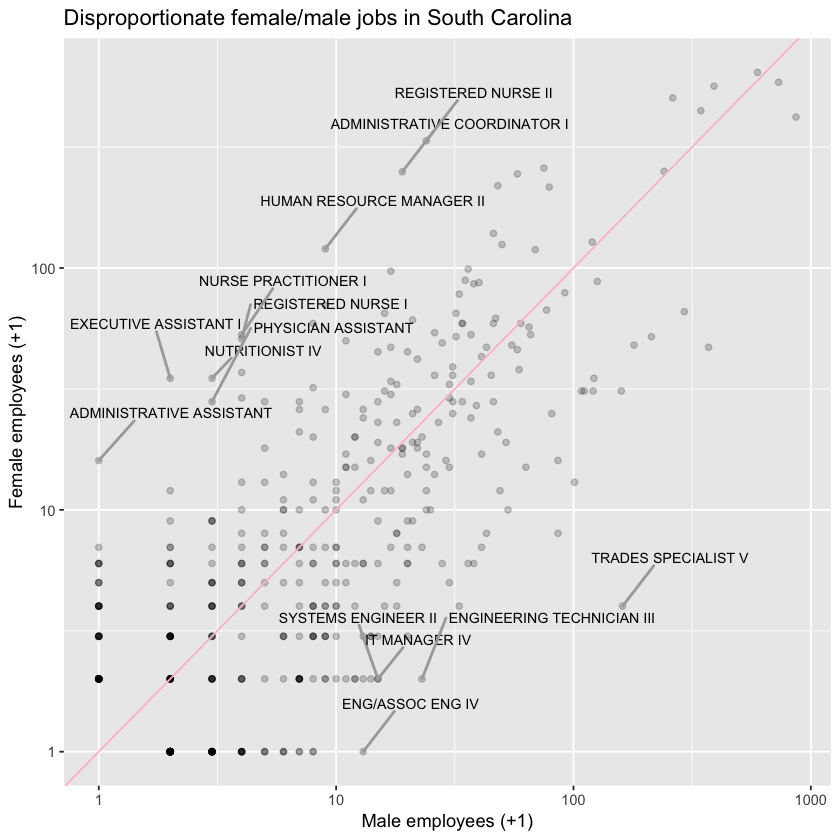

In [8]:
sc_salaries_with_sex %>%
    group_by(`Job`) %>%
    nest() %>%
    mutate(
        `f_count`=map(data, count_sexes, sex='female'),
        `m_count`=map(data, count_sexes, sex='male'),
    ) %>%
    unnest(f_count, m_count, .drop = T) %>%
    ggplot(aes(x=`m_count` + 1, y=`f_count` + 1)) +
        geom_point(alpha=0.2) +
        geom_abline(intercept=0, slope=1, color="pink") +
        geom_text_repel(
            data=. %>%
            filter(
                (`f_count` > 10 & `f_count`/`m_count` > 13) |
                (`m_count` > 10 & `m_count`/`f_count` > 13)
            ),
            aes(label=`Job`),
            size=3,
            nudge_y=.2,
            nudge_x=.2,
            segment.size=0.8,
            segment.color="darkgray"
        ) +
        scale_x_log10() +
        scale_y_log10() +
        labs(
            x='Male employees (+1)',
            y='Female employees (+1)',
            title='Disproportionate female/male jobs in South Carolina'
        )
